# Simulating Asset Prices using Geometric Brownian Motion and the Black-Scholes Model

This project explores two foundational ideas in quantitative finance:

**Geometric Brownian Motion (GBM)**: used to simulate stock price evolution over time.

**Black-Scholes-Merton (BSM) model**: used to price European-style call and put options.

These tools are widely used in hedge funds, banks, and algorithmic trading firms. The goal is to simulate stock prices and calculate fair option prices using these models in Python.


## Step 1: Import Libraries

We import essential Python libraries for numerical computation, statistics, and plotting:

- `numpy`: for array-based math and random number generation
- `matplotlib`: for visualizing price paths and option prices
- `scipy.stats.norm`: for the normal cumulative distribution function used in Black-Scholes


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

## Step 2: Simulating Stock Prices using Geometric Brownian Motion (GBM)

**GBM** is a stochastic process where the log of asset prices follows a Brownian motion with drift.

It's the standard model used in finance to simulate how stock prices evolve, assuming:

- Constant drift (expected return)
- Constant volatility
- Lognormal distribution of prices
- No arbitrage and frictionless markets

The GBM formula is:$$
S_{t+1} = S_t \cdot \exp\left[\left(\mu - \frac{1}{2} \sigma^2\right)\Delta t + \sigma \sqrt{\Delta t} \cdot Z\right]
$$


Where:
- S(t) : current price
- μ : expected return
- σ : volatility
- Z : random standard normal variable

We simulate multiple paths (e.g., 100) to see how prices could evolve over time.



In [3]:
def simulate_gbm_paths(S0, mu, sigma, T, N, M):
    dt = T / N
    paths = np.zeros((M, N+1))
    paths[:, 0] = S0
    for t in range(1, N + 1):
        z = np.random.normal(0, 1, M)
        paths[:, t] = paths[:, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return paths

## Visualizing GBM Paths

We plot a few simulated paths from our GBM function to see how stock prices evolve over time. Each line represents a possible future price path of the same stock.

This gives a sense of **market uncertainty** and **path dependency**.


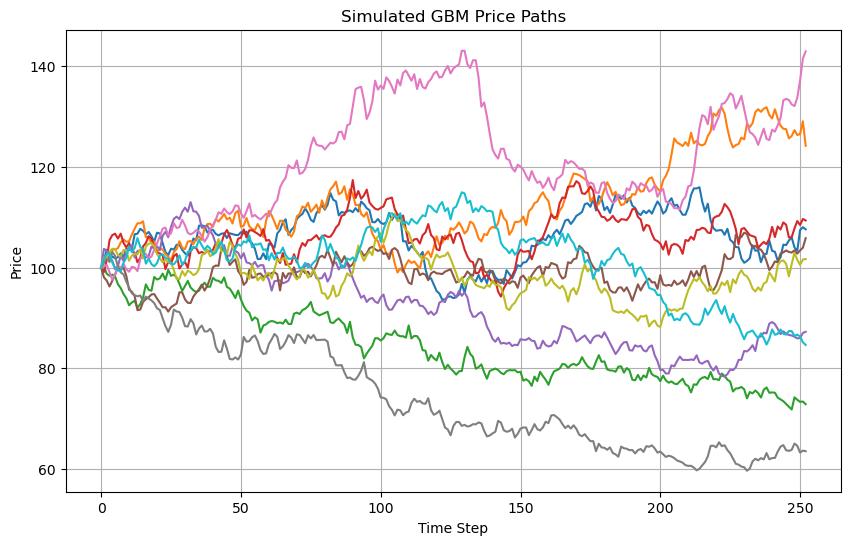

In [4]:
paths = simulate_gbm_paths(100, 0.05, 0.2, 1, 252, 100)

plt.figure(figsize=(10,6))
for i in range(10):
    plt.plot(paths[i])
plt.title("Simulated GBM Price Paths")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.grid(True)
plt.show()

## Step 3: Option Pricing using the Black-Scholes-Merton (BSM) Model

The **Black-Scholes model** is used to calculate the theoretical price of European-style options.

Assumptions:
- Stock follows GBM
- No dividends
- Constant interest rate, volatility, and frictionless markets

### Black-Scholes Formula (Call Option):
$$
C = S \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2)
$$

Where:
- S: current stock price
- K: strike price
- r: risk-free rate
- T: time to maturity
- σ: volatility
- N(d1), N(d2): standard normal cumulative distribution functions



In [5]:
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

## Testing Option Pricing

We now calculate the fair price of a call and a put option using our `black_scholes_price()` function.

These prices help investors make decisions about buying or selling options.


In [6]:
call_price = black_scholes_price(100, 105, 1, 0.05, 0.2, 'call')
put_price = black_scholes_price(100, 105, 1, 0.05, 0.2, 'put')
print(f"Call Option Price: {call_price:.2f}")
print(f"Put Option Price: {put_price:.2f}")

Call Option Price: 8.02
Put Option Price: 7.90


## Step 4: Visualizing Option Price vs Volatility

Volatility is a key driver of option prices.

We plot how a **call option’s price changes** as volatility increases — keeping all other inputs constant.

This illustrates the **positive Vega** of a call option: more volatility → more value (more chance of large gains).


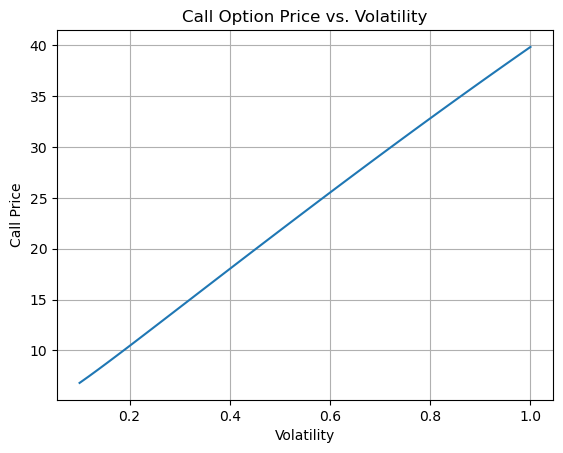

In [7]:
vols = np.linspace(0.1, 1, 50)
call_prices = [black_scholes_price(100, 100, 1, 0.05, v, 'call') for v in vols]
plt.plot(vols, call_prices)
plt.title("Call Option Price vs. Volatility")
plt.xlabel("Volatility")
plt.ylabel("Call Price")
plt.grid(True)
plt.show()

## Step 5: Monte Carlo Option Pricing

While the Black-Scholes formula gives an analytical price under idealized assumptions, Monte Carlo simulation lets us estimate option values by sampling many possible future paths:

1. Simulate \(M\) terminal prices \(S_T\) under GBM.  
2. Compute payoffs: \(\max(S_T - K, 0)\) for calls or \(\max(K - S_T, 0)\) for puts.  
3. Discount the average payoff back to today:
   $$
   \text{Price} \;=\; e^{-rT}\,\mathbb{E}[\text{payoff}]
   $$

This approach is easy to extend (exotic payoffs, barriers, etc.) and validates our BSM results.


In [13]:
def monte_carlo_option_price(S0, K, T, r, sigma, M=10000, option_type='call'):
    Z = np.random.normal(0, 1, M)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    
    if option_type == 'call':
        payoff = np.maximum(ST - K, 0)
    else:
        payoff = np.maximum(K - ST, 0)
    return np.exp(-r * T) * np.mean(payoff)

# Example comparison
S0, K, T, r, sigma = 100, 100, 1, 0.05, 0.2
mc_call = monte_carlo_option_price(S0, K, T, r, sigma, M=50000, option_type='call')
bs_call = black_scholes_price(S0, K, T, r, sigma, 'call')
print(f"BSM Call: {bs_call:.4f}, Monte Carlo Call: {mc_call:.4f}")

BSM Call: 10.4506, Monte Carlo Call: 10.4017


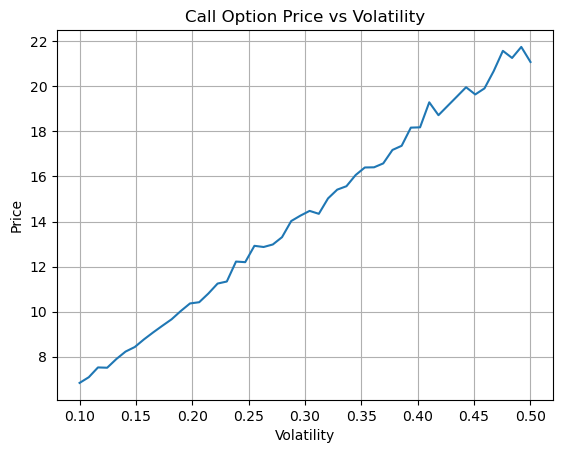

In [14]:
vols = np.linspace(0.1, 0.5, 50)
prices = [monte_carlo_option_price(100, 100, 1, 0.05, v) for v in vols]
plt.plot(vols, prices)
plt.title("Call Option Price vs Volatility")
plt.xlabel("Volatility")
plt.ylabel("Price")
plt.grid(True)
plt.show()
